# Trabalho Prático 2
## *Data Augmentation*

### Imports Globais

<br/>

Todos os restantes imports serão feitos nas secções que assim os exigem.

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import re
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
from PIL import Image

### Variáveis Globais

<br/>

O do **batchSize** é um parâmetro importante quando se treina uma Rede, podendo influenciar a velocidade e a generalização, não necessariamente na mesma direção. Através de algumas pesquisar o grupo decidiu manter o valor padrão, já que não notamos qualquer influência significativa nos resultados obtidos.

1. **imgSize** Tamanho da Imagem a ser usado na criação do Modelo CNN
2. **batchSize** Número de Amostras a ser propagadas pela CNN

Para este segundo Trabalho Prático acabamos por fazer uso da funcionalidade implementada no Trabalho Prático anterior - aplicação de mais de uma Rede para *Training*. Dessa forma, definimos já um conjunto de cinco *Nets* para que depois pudesse também ser feita uma avaliação geral dos resultados das mesmas.

3. **nets** Número de Redes usadas para *Training*

In [2]:
imgSize = 32
batchSize = 32
nets = 5
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Funções Auxiliares

<br/>

Funções auxiliar já existentes no código inicialmente fornecido pelo docente.
Estas funções são importantes quando se está a carregar todo o lote de imagens a usar nos vários *datasets*.

In [3]:
data_dir = pathlib.Path('gtsrb/train_images/')
classNames = np.array(os.listdir(data_dir))

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [4]:
import tensorflow_addons as tfa

def process_image(image, label):
    
    # Resize Inicial - Aumentar tamanho da imagem para o dobro
    # Isto favorece a perceção da mesma, o que acaba por melhorar os resultados
    image = tf.image.resize(image, (imgSize*2,imgSize*2))
    
    # Rotation.
    r = tf.random.uniform(shape=(), minval=0, maxval=1)* 0.5 - 0.25
    image = tfa.image.rotate(image, r)
    
    # Flip - Acabamos por não usar dado que não valorizava os resultados finais
    #image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_flip_up_down(image)
    
    # Translation
    rx = tf.random.uniform(shape=(), minval=0, maxval=1) * 20 - 10
    ry = tf.random.uniform(shape=(), minval=0, maxval=1) * 8 - 4
    image = tfa.image.translate(image, [rx, ry])
      
    # Adjust hue, saturation, value of an RGB image randomly in YIQ color
    # Tentamos fazer de forma separada mas não valorizava os resultados finais
    image = tfa.image.random_hsv_in_yiq(image, 0.3, 0.9, 1.1, 0.9, 1.3)
    #image = tf.image.random_contrast(image, 0.7, 1.0)
    #image = tf.image.random_saturation(image, 0.9, 2.0)
    #image = tf.image.random_hue(image, 0.01) 
    
    # Crop - Acabamos por não usar dado que não valorizava os resultados finais
    #frac = random.uniform(0.7,1.0)
    #image = tf.image.central_crop(image, frac)
    
    # Resize Final - Tamanho da imagem volta a ser o estipulado
    image = tf.image.resize(image, (imgSize,imgSize))
    
    # Brilho.
    image = tf.image.adjust_brightness(image, tf.random.uniform(shape=(), minval=0.0, maxval=0.3) - 0.1)

    # Clips tensor values to a specified min and max
    image = tf.clip_by_value(image, 0, 1)
    
    return image, label

### Modelo de cada *Convolutional Neural Network*

<br/>

Este modelo foi totalmente alterado perante o que foi incialmente fornecido. Com algumas pesquisas, encontramos a arquitetura **LeNet-5**, que nos pareceu ser uma alternativa benéfica para o alcance de bons resultados. 

<p class align="center">
    <img src="LeNet-5 Architecture.png"/>
</p>


**Esta arquitura consiste em:**

- Dois conjuntos de *Convolutional Layers* e *Pooling Layers*
- Uma *Flattening Convolution Layer*
- Duas *Fully-Connected Layers*
- Classificador *softmax* 

**No entanto, as nossas *Convolutionals Neurals Networks* apresentam algumas melhorias relativamente a esta arquitetura:**

- Dois filtros 3x3 ao invés de apenas um filtro 5x5
    - Passamos a ter *Convolutional Layers* não lineares com um filtro 5x5
- Mudamos as *Pooling Layers* ao definirmos uma *Convolutional Layer* com *stride* 2
    - Passamos a ter *Pooling Layers* com capacidade de aprendizagem
- Usamos *relu* ao invés do *sigmoid*
- Adicionamos *Batch Normalization*
- Adicionamos *Dropout*

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

model = [0] * nets

for j in range(nets):
    
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (imgSize, imgSize, 3)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(43, activation='softmax'))

    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

### Diagrama do modelo da *Convolutional Neural Network* (CNN)

<br/>

Estando o modelo de cada CNN definido, podemos imprimir um diagrama que nos permite validar aquilo que falamos anteriormente. Através dele percebemos as várias camadas adicionadas e as restantes aplicações a cada uma dessas mesmas camadas.

Como o modelo é igual para todas as Redes fazemos logo a impressão do primeiro modelo.

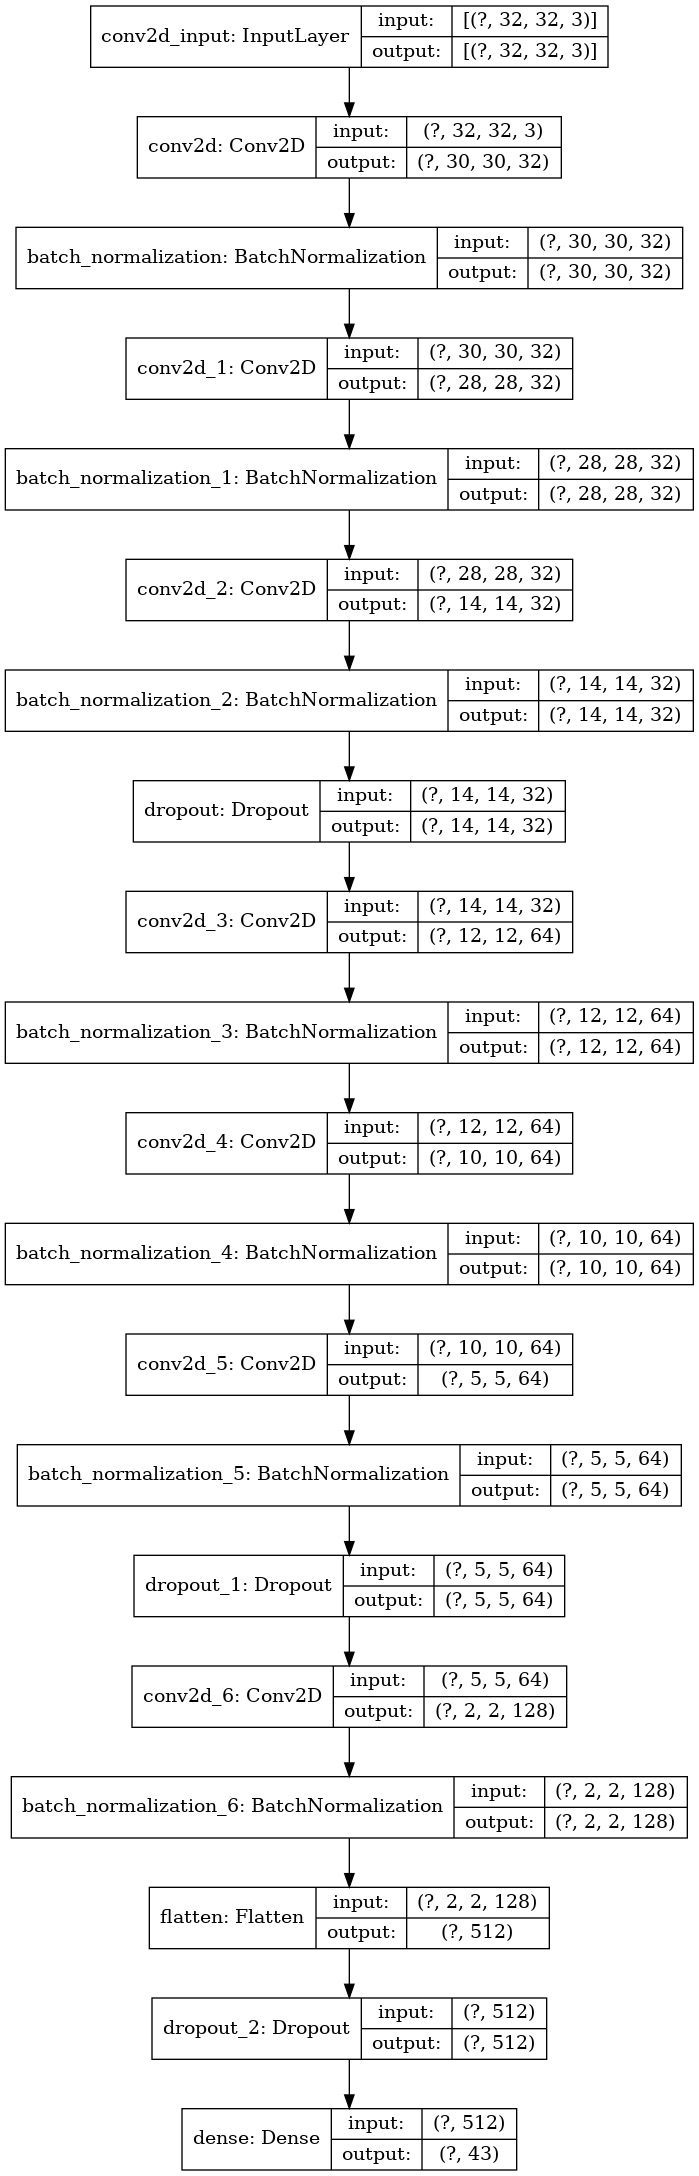

In [6]:
tf.keras.utils.plot_model(model[0], 'diagramaModelo.png', show_shapes=True)

### Tabela do modelo da *Convolutional Neural Network*

<br/>

Processo similar ao anterior mas é mostrado em modo tabela. 

In [7]:
print(model[0].summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0

### Divisão dos *datasets* de Treino e Validação

<br/>

A ideia deste processo consiste em dividir o conjunto de dados massivo fornecido na pasta *train_images*, de modo a conseguirmos obter *datasets* diferentes para o Treino e Validação.
Inicialmente estávamos a usar apenas um *dataset*, sem qualquer divisão, o que não fazia sentido dada a necessidade de treinarmos cada Rede consoante o *dataset* de Treino e Validação.

Esta parte sofreu alterações relativamente ao Trabalho Prático anterior, dado que notamos que esta divisão deveria ser feita usando-se uma série inteira para a Validação. Com isso em mente, estabeleceu-se um novo algoritmo que permite agrupar todas as sequências de imagens de cada uma das pastas.
Com todas as sequências obtidas, 20% das mesmas são usadas para o *dataset* de Validação e as restantes 80% para o *dataset* de Treino.

In [8]:
# Arrays para guardar Paths das imagens para cada dataset
training = []
validation = []
totalImagens = 0

# Diretoria Global a ambos os datasets
path = 'gtsrb/train_images/'
dir = os.listdir(path)

isImage = '[0-9]{5}_[0-9]{5}\.png'

def imagesOnly(filesList):
    for file in filesList:
        if not re.search(isImage, file):
            filesList.remove(file) # Remove ficheiros que não sejam uma imagem
    return filesList

def groupSequences(imagesList):
    newList = []
    sequenceList = []
    curr_seq = '00000'
    
    for image in imagesList:
        if (image[0:5] == curr_seq):
            sequenceList.append(image)
        else:
            curr_seq = image[0:5]
            newList.append(sequenceList)
            sequenceList = [image]
            
    newList.append(sequenceList)
    return newList

for namePath in dir:
    images = imagesOnly(sorted(os.listdir(path + namePath)))
    totalImagens += len(images)
    
    sequences = groupSequences(images)
    maxValidationSet = int(len(sequences) * 0.2) # 20% das sequências vão para o Validation Dataset
    currValidationSet = 0
    
    for s in sequences:
        if (currValidationSet < maxValidationSet):
            for i in s: # Adiciona a sequência inteira no Validation
                validation.append(path + namePath + '/' + i)
                currValidationSet += 1
        else:
            for i in s: # Adiciona a sequência inteira no Training
                training.append(path + namePath + '/' + i)

### Carregar Imagens dos *datasets* de Treino e Validação

<br/>

Esta secção trata de carregar as imagens para os *datasets* de Treino e Validacão.
Como já temos os arrays para o Treino e Validação, executa-se o mesmo processo para ambos.

In [9]:
listDatasetTraining = tf.data.Dataset.list_files(training)
listDatasetValidation = tf.data.Dataset.list_files(validation)

datasetTraining = listDatasetTraining.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
datasetTrainingLength = [i for i,_ in enumerate(datasetTraining)][-1] + 1

datasetValidation = listDatasetValidation.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
datasetValidationLength = [i for i,_ in enumerate(datasetValidation)][-1] + 1

### Preparar os *datasets* de Treino e Validação

<br/>

Preparação dos *datasets* de Treino e Validação.

Aplica-se aqui o processamento de imagens definido na função auxiliar criada para o efeito.

In [10]:
datasetTraining = datasetTraining.cache()
datasetTraining = datasetTraining.shuffle(buffer_size = datasetTrainingLength)
datasetTraining = datasetTraining.prefetch(buffer_size=AUTOTUNE)
datasetTraining = datasetTraining.map(process_image)
#datasetTraining = d1.concatenate(d2)
datasetTraining = datasetTraining.batch(batch_size=batchSize)
datasetTraining = datasetTraining.repeat()

datasetValidation = datasetValidation.cache()
datasetValidation = datasetValidation.shuffle(buffer_size = datasetValidationLength)
datasetValidation = datasetValidation.prefetch(buffer_size=AUTOTUNE)
datasetValidation = datasetValidation.map(process_image)
#datasetValidation = d1.concatenate(d2)
datasetValidation = datasetValidation.batch(batch_size=batchSize)
datasetValidation = datasetValidation.repeat()

### Visualização de algumas Imagens do *dataset* de Treino
<br/>

Demonstração de algumas imagens que estão presetnes no *dataset* de Treino.

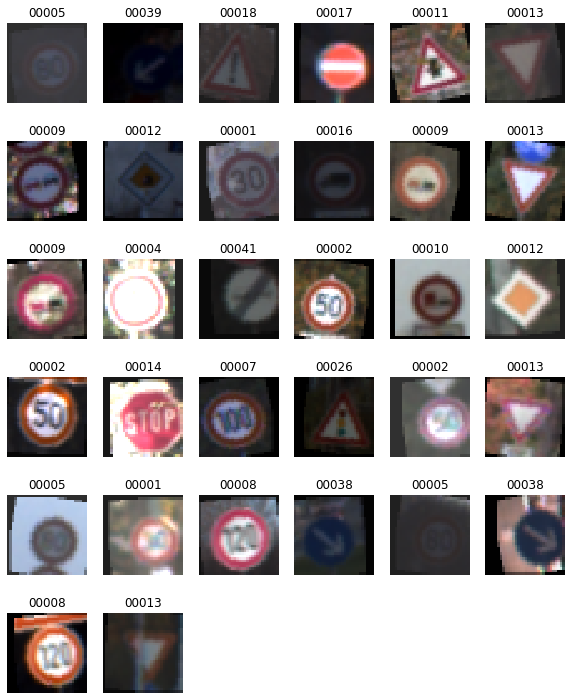

In [11]:
def show_batch(image_batch, label_batch):
  columns = 6
  rows = batchSize / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(batchSize):
      ax = plt.subplot(rows, columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')
        
        
image_batch, label_batch = next(iter(datasetTraining))        
show_batch(image_batch, label_batch.numpy())

### Carregar Imagens e Preparar o *dataset* de Teste
<br/>

Esta secção trata de carregar as imagens para o *dataset* de Teste, executando também o processo de preparação.
Note-se que é mais simples que nos *datasets* anteriores, dado que já existe uma pasta individualizada para este efeito.

In [12]:
datasetTest = tf.data.Dataset.list_files("gtsrb/test_images/*/*.png")

datasetTest = datasetTest.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
datasetTest = datasetTest.batch(batch_size=batchSize)

### Informação acerca do número de Imagens de cada *dataset*

<br/>

Com os três *datasets* totalmente preparados pode ser feito um apanhado geral do conteúdo de cada um deles.

In [13]:
print("Total de imagens presentes na pasta de treino: ", totalImagens)
print("Total de imagens usadas no dataset de treino: ", datasetTrainingLength)
print("Total de imagens usadas no dataset de validação: ", datasetValidationLength)
print("\nTotal de imagens usadas no dataset de teste: ", [i for i,_ in enumerate(datasetTest)][-1] + 1)

Total de imagens presentes na pasta de treino:  39209
Total de imagens usadas no dataset de treino:  37919
Total de imagens usadas no dataset de validação:  1290

Total de imagens usadas no dataset de teste:  395


### Treino de cada *Convolutional Neural Network*

<br/>

É feito o treino para cada um das Redes criadas anteriormente. Neste caso, e conforme já foi referido, estamos a usar cinco Rede, pelo que serão todas treinadas.

Escolhemos 30 *epochs* porque ao fim de alguns testes verificamos que este valor seria o mais indicado para obter o maior valor de *accuracy*. 

**Esta conclusão ficará mais clara depois de observarmos os gráficos que vamos apresentar na secção a seguir.**

In [14]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

history = [0] * nets
epochs = 30

for j in range(nets):
    
    history[j] = model[j].fit(
        datasetTraining,
        steps_per_epoch = datasetTrainingLength/batchSize,
        epochs = epochs,
        validation_data = datasetValidation,
        validation_steps = datasetValidationLength/batchSize
    )

Train for 1184.96875 steps, validate for 40.3125 steps
Epoch 1/30
1185/1184 [==============================] - 31s 26ms/step - loss: 1.5047 - accuracy: 0.5797 - val_loss: 1.4039 - val_accuracy: 0.5876
Epoch 2/30
1185/1184 [==============================] - 28s 23ms/step - loss: 0.4173 - accuracy: 0.8704 - val_loss: 0.7046 - val_accuracy: 0.8016
Epoch 3/30
1185/1184 [==============================] - 25s 21ms/step - loss: 0.2467 - accuracy: 0.9237 - val_loss: 0.7172 - val_accuracy: 0.7845
Epoch 4/30
1185/1184 [==============================] - 26s 22ms/step - loss: 0.1767 - accuracy: 0.9464 - val_loss: 0.4660 - val_accuracy: 0.8403
Epoch 5/30
1185/1184 [==============================] - 25s 21ms/step - loss: 0.1441 - accuracy: 0.9558 - val_loss: 1.0269 - val_accuracy: 0.7411
Epoch 6/30
1185/1184 [==============================] - 25s 21ms/step - loss: 0.1284 - accuracy: 0.9610 - val_loss: 1.4424 - val_accuracy: 0.7667
Epoch 7/30
1185/1184 [==============================] - 25s 21ms/step

1185/1184 [==============================] - 25s 21ms/step - loss: 0.0450 - accuracy: 0.9857 - val_loss: 0.4120 - val_accuracy: 0.8938
Epoch 22/30
1185/1184 [==============================] - 25s 21ms/step - loss: 0.0415 - accuracy: 0.9874 - val_loss: 0.4155 - val_accuracy: 0.8992
Epoch 23/30
1185/1184 [==============================] - 26s 22ms/step - loss: 0.0437 - accuracy: 0.9866 - val_loss: 0.4438 - val_accuracy: 0.9000
Epoch 24/30
1185/1184 [==============================] - 25s 21ms/step - loss: 0.0409 - accuracy: 0.9876 - val_loss: 0.3726 - val_accuracy: 0.9163
Epoch 25/30
1185/1184 [==============================] - 26s 22ms/step - loss: 0.0443 - accuracy: 0.9862 - val_loss: 0.2595 - val_accuracy: 0.9279
Epoch 26/30
1185/1184 [==============================] - 25s 21ms/step - loss: 0.0395 - accuracy: 0.9869 - val_loss: 0.3381 - val_accuracy: 0.9271
Epoch 27/30
1185/1184 [==============================] - 25s 21ms/step - loss: 0.0380 - accuracy: 0.9880 - val_loss: 0.3000 - val_

### Gráficos resultados obtidos no treino de cada *Convolutional Neural Network*

<br/>

Esboçamos dois gráficos relativamente aos resultados obtidos para o treino feito em cada Rede. Para cada Rede são desenhados dois gráficos. 

**São eles os seguintes:**

- **Training and Validation Accuracy** permite verificar os valores de *accuracy* no decorrer de cada *epoch*
- **Training and Validation Loss** permite verificar os valores de *loss* no decorrer de cada *epoch*

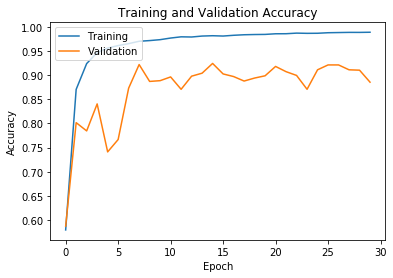

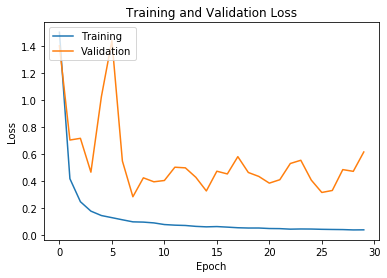

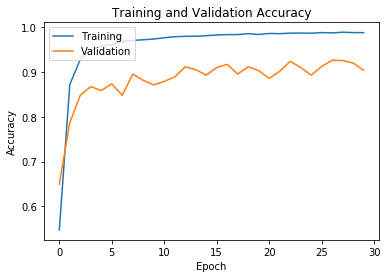

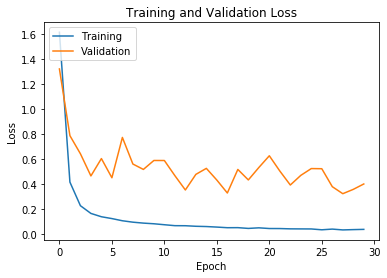

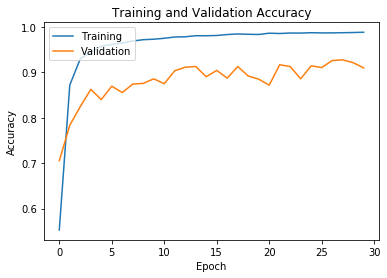

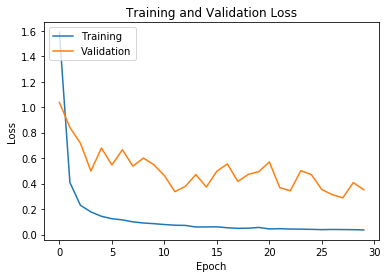

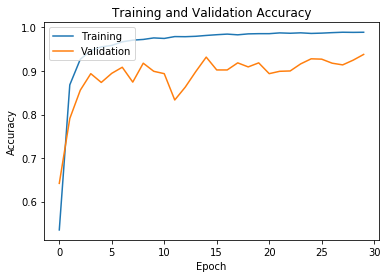

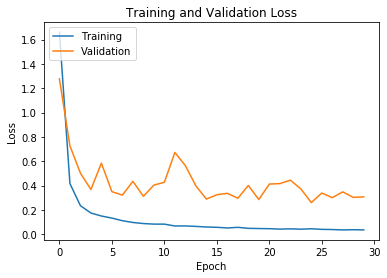

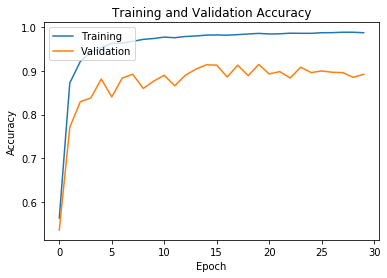

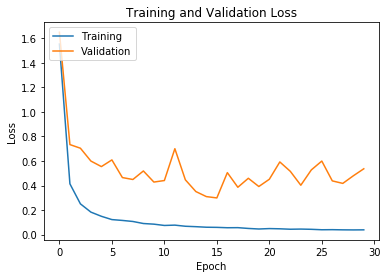

In [15]:
for j in range(nets):
    
    # Summarize History for Accuracy
    plt.plot(history[j].history['accuracy'])
    plt.plot(history[j].history['val_accuracy'])
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()

    # Summarize History for Loss
    plt.plot(history[j].history['loss'])
    plt.plot(history[j].history['val_loss'])
    plt.title('Training and Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()

### Teste de cada *Convolutional Neural Network*

<br/>

Faz-se o teste para cada uma das Redes. Com este teste feito conseguimos obter o valor final de *accuray* que realmente importa para avaliar a precisão do nosso modelo.

In [16]:
resultados = []
for j in range(nets): 
    resultados.append(model[j].evaluate(datasetTest))

395/395 [==============================] - 1s 4ms/step - loss: 0.0459 - accuracy: 0.9873


### Observações Finais

<br/>

Para conseguirmos obter uma análise dos testes efetuados, fez-me a determinação da **Média**, **Mediana** e **Desvio Padrão**. Estes valores permitem perceber melhor o comportamento da Rede, dado que se sabe que a *accuracy* pode variar devido um conjunto variado de fatores, sendo um deles a forma como se faz a *Data Augmentation* e as imagens que este processamento **aleatório** produz.

**Atente-se nos valores da Média, Mediana e Desvio Padrão:**

In [17]:
accuracy = []
for r in resultados:
    accuracy.append(r[1])
    
print("Média: {0:.2%}".format(np.mean(accuracy)))
print("Médiana: {0:.2%}".format(np.median(accuracy)))
print("Desvio Padrão: " + str(np.std(accuracy)))

Média: 98.77%
Médiana: 98.73%
Desvio Padrão: 0.0024718337


- Dado que a média se refere ao ponto de equilíbrio da concentração de dados de uma determinada distribuição, podemos concluir que estamos perante uma **boa** média, tendo em conta que a mesma aponta para uma percentagem de 99% para a precisão dos testes efetuados.
- A mediana pode dar uma ideia melhor, tendo em conta que não é tão "distorcida" por valores extremamente altos ou baixos. O valor da mesma revela-se também ele promissor, igualando-se praticamente ao da média.


<br/>

**Fazendo-se agora um apanhado final da evolução do valor da *accuracy* ao longo do desenvolvimento destes Trabalhos Práticos:**

<br/>


|      Valor da *Accuracy*       |   Inicial    | Trabalho Prático 1 | Trabalho Prático 2 |
| :----------------------------: | :----------: | :----------------: | :----------------: |
|           Com 1 Rede           | 0.9500 = 95% |    0.9787 ≅ 98%    |    0.9872 ≅ 99%    |
| Com 5 Redes (Média Aritmética) |      X       |    0.9800 = 98%    |    0.9877 ≅ 99%    |

<br/>

- Inicialmente, sem efetuarmos qualquer alteração ao código obtinhamos uma accuracy de 0.9500, ou seja, 95%
- **Dividindo-se o conjunto de dados para Treino, obtendo-se o *dataset* de Treino e Validação e alterando-se o modelo da rede CNN em si obtemos:**
    - Ao usarmos mais do que uma CNN verificamos que algumas dessas CNNs chegam a ter uma *accuracy* de 0.9800, ou seja, 98%;
    - Optando por apenas uma CNN (conforme o resultado acima assim o comprova) obtemos uma accuracy de 0.9787, o que arredondado dá o valor de 98%.
- **Com a modificação desta divisão de *datasets* efetuada no primeiro Trabalho Prático e definindo-se um processamento das imagens tanto do *dataset* de Validação como de Treino obtemos:**
    - Uma *accuracy* de aproximadamente 99%, tanto usando uma CNN como as cinco que se definiu no inicío deste TP.
- Note-se que há redes para quais o valor de *accuracy* chega mesmo a ser 99%, o que prova a ideia de que todos estes valores dependem da aleatoriedade no processamento das imagens.

<br/>

Acreditamos que 99% é um valor excelente para esta segunda fase, não só porque sabemos que 1% faz toda a diferença para a *accuracy* mas porque notamos que a *Data Augmentation* é um método que pode realmente influenciar nestes valores.